This is a fourth post in a series of exercises to predict popularity of a blog post on NYTimes website.

Previous posts are located here:

- [Naïve Random Forest Classifier](http://r-train.ru/naive-random-forest-classifier/). This post is about fitting plain vanilla Random Forest on readily available features, like sections where post was published, date, time, and bag of words extracted from Headline and Abstract.  

- [Fitting models on low signal-to-noise data](http://r-train.ru/fitting-models-on-low-signal-to-noise-data/). This is somewhat theoretical post showing some theory behind why Random Forest can perform poorly on low signal-to-noise data sets.  

- [Feature selection 1: Univariate](http://r-train.ru/feature-selection-1-univariate/) and [Feature selection 2: Logistic Regression](http://r-train.ru/feature-selection-2-logistic-regression-2/). These two posts show several approaches to feature selection (reducing # of features) and compare the performance of in-model vs out-of-model feature selection.  

In this post I employ a different approach motivated by this [post](http://nbviewer.ipython.org/gist/mattsco/8dddf256244fb7d47d47). This approach suggests fitting models to proper names (entities in Python jargon).

The main difference from what I did before is that instead of bag of words I will generate bag of entities ('boe'). 

## Load data

In [ ]:
import numpy as np
import pandas as pd
seed = 1
train = pd.read_csv('/home/sergey/R_Analyttics_Edge_MITx/kaggle/NYTimesBlogTrain.csv')
test = pd.read_csv('/home/sergey/R_Analyttics_Edge_MITx/kaggle/NYTimesBlogTest.csv')

## Do some data munging

In [262]:
combo = pd.merge(train, test, how='outer')
combo = combo.drop('Popular', axis=1)
y = train['Popular']
combo_clean = combo.fillna('empty')
combo_clean['LogWC'] = np.log(.1+ combo_clean['WordCount'])

## Extract date/time and bin time

In [263]:
import datetime as dt
combo_clean['date'] = combo_clean['PubDate'].apply(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%A')
)
combo_clean['hour'] = combo_clean['PubDate'].apply(
    lambda x: int(dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%H'))
)
combo_clean[['PubDate','date','hour']][1:5]
bins = np.linspace(0,24,5)
labels = ['night', 'morning', 'afternoon', 'evening']
combo_clean['hour_bins'] = pd.cut(combo_clean['hour'], bins=bins, labels=labels)
combo_clean.drop(['hour', 'WordCount', 'PubDate'], axis=1, inplace=True)

## Dummify section names, dates and hours

In [264]:
import sklearn.feature_extraction.text as txt
categorical_dummies = pd.get_dummies(combo_clean[['NewsDesk','SectionName','SubsectionName','date']])
categorical_hours = pd.get_dummies(combo_clean['hour_bins'].apply(str))

## Extract entities from headlines and abstracts

In [ ]:
import nltk

def extractEntities(text):
    sentences= nltk.sent_tokenize(text)
    entities= {}
    for sent in sentences:
        chunks = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)))
        for chunk in chunks:
            if type(chunk) != tuple:
                txt = str(chunk)
                txt = "_".join(" ".join(txt.split('/')).split()[1::2])
                entities[txt] = 1
    return " ".join(dict(entities).keys())


entities = combo_clean['Abstract'].apply(extractEntities)

In [267]:
import sklearn.feature_extraction.text as txt


countVec = txt.CountVectorizer(min_df=2, token_pattern=r'\w{1,}', stop_words='english',
                               strip_accents='unicode', lowercase=True)
boe = countVec.fit_transform(entities)
boe.shape

## Calculate headline freq count

In [269]:
headlineCount = combo_clean.Headline.map(combo_clean.Headline.value_counts())

## Put everything together

In [290]:
data = np.concatenate((categorical_dummies,
                       categorical_hours,
                       boe.todense(),
                       combo_clean['LogWC'].to_frame(),
                       headlineCount.to_frame()), axis=1)


data_train = data[: train.shape[0],:]
data_test  = data[train.shape[0]:,:]
import sklearn.cross_validation as cv
data_train, data_val, y_train, y_val = cv.train_test_split(data_train, y, test_size=.2, random_state=seed)

(8402, 1768)

## Tune hyperparameters for logistic regression

In [292]:
import sklearn.linear_model as lm
import sklearn.cross_validation as cv
import sklearn.grid_search as grd
import sklearn.metrics as mts

In [293]:
lg_mod = lm.LogisticRegression(random_state=seed, class_weight='auto')
lg_mod

LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0)

In [294]:
param = {'C': np.logspace(-2,2.,50),
        'penalty': ['l1', 'l2']}
gr = grd.GridSearchCV(lg_mod, param_grid=param, scoring = 'roc_auc', cv=5)
gr

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.20679e-02,   1.45635e-02,   1.75751e-02,
         2.12095e-02,   2.55955e-02,   3.08884e-02,   3.72759e-02,
         4.49843e-02,   5.42868e-02,   6.55129e-02,   7.90604e-02,
         9.54095e-02,   1.15140e-01,   1.38950e-01,   1.67683e-01,
         2.0235...7e+01,   5.68987e+01,   6.86649e+01,
         8.28643e+01,   1.00000e+02]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [295]:
gr.fit(data_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.20679e-02,   1.45635e-02,   1.75751e-02,
         2.12095e-02,   2.55955e-02,   3.08884e-02,   3.72759e-02,
         4.49843e-02,   5.42868e-02,   6.55129e-02,   7.90604e-02,
         9.54095e-02,   1.15140e-01,   1.38950e-01,   1.67683e-01,
         2.0235...7e+01,   5.68987e+01,   6.86649e+01,
         8.28643e+01,   1.00000e+02]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [296]:
auc_std  = np.array([np.std(i[2]) for i in gr.grid_scores_])
auc_mean = np.array([np.mean(i[2]) for i in gr.grid_scores_])
penalty  = np.array([i[0]['penalty'] for i in gr.grid_scores_])
lower_l1 = auc_mean[penalty == 'l1'] - 2*auc_std[penalty == 'l1']
upper_l1 = auc_mean[penalty == 'l1'] + 2*auc_std[penalty == 'l1']
lower_l2 = auc_mean[penalty == 'l2'] - 2*auc_std[penalty == 'l2']
upper_l2 = auc_mean[penalty == 'l2'] + 2*auc_std[penalty == 'l2']

In [297]:
% matplotlib inline
import matplotlib.pyplot as plt

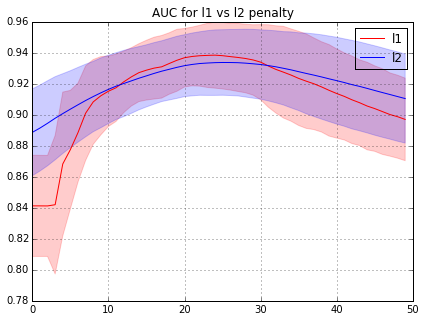

In [298]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(auc_mean[penalty == 'l1'], 'r', label = 'l1')
plt.fill_between(np.arange(len(upper_l1)),upper_l1, lower_l1, color='r', alpha=.2)
plt.plot(auc_mean[penalty == 'l2'], 'b', label = 'l2')
plt.fill_between(np.arange(len(upper_l2)),upper_l2, lower_l2, color='b', alpha=.2)
plt.legend(numpoints=1)
plt.grid()
plt.title('AUC for l1 vs l2 penalty')
plt.show()

In [299]:
gr.best_estimator_

LogisticRegression(C=0.9102981779915218, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0)

In [300]:
gr.best_score_

0.93847893420421702

## Validating LogisticRegression on held-out subset

In [301]:
best_param = gr.best_estimator_.get_params()
lg_mod.set_params(C = best_param['C'],class_weight = best_param['class_weight'],
                  penalty = best_param['penalty'], random_state = seed)

LogisticRegression(C=0.9102981779915218, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0)

In [302]:
lg_mod.fit(data_train, y_train)

LogisticRegression(C=0.9102981779915218, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0)

In [303]:
import sklearn.metrics as mts
mts.roc_auc_score(y_val, lg_mod.predict_proba(data_val)[:,1])

0.93106125508674231

## Conclusions

Relying on proper names (entities) made quite a significant impact on model performance.

Models trained on section names, day of week, part of day, and bag of words out of Abstract and Headline produced:

- **0.91514** for [Logistic Regression](http://r-train.ru/feature-selection-2-logistic-regression/) (l2 regularized via cv).
- **0.92616** for [Random Forest](http://r-train.ru/naive-random-forest-classifier/) with ~ 3'500 features.

This model, Logistic Regression, was trained on section names, day of week, part of day, and bag of words out of **proper names** (entity names). The AUC achieved is **0.93106**. Actually, the superiority of such a model makes perfect sense: people are more prone to comment on posts about famous personalities or places, than about abstract nameless subjects.

All the models were tuned via cross-validation on train data set, and validated on the held-out subset the models had not seen before.
